In [1]:
#initialize dependencies, h2o as primary
import datetime  # for timestamp
from interpret import show  # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC  # ROC measure for ebm
import itertools  # for cartesian product of parameters
import matplotlib.pyplot as plt  # basic plotting
import numpy as np  # for basic array manipulation
import pandas as pd  # for dataframe manipulation
import seaborn as sns  # slightly better plotting
import time  # for timers
import random   # to sample from lists
from sklearn.metrics import accuracy_score, f1_score   # for selecting model cutoffs

# set numpy random seed for better reproducibility
SEED = 12345

# set number of threads
NTHREAD = 4

In [2]:
# start global timer
tic = time.time()

In [3]:
#import data (test data will not be used for model fitting)
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

# Feature Assignment (Parametric Model)

In [4]:
#assign x and y features
y_name = 'high_priced'
x_names = [
    'term_360', 'conforming', 'debt_to_income_ratio_missing',
    'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
    'intro_rate_period_std', 'property_value_std', 'income_std',
    'debt_to_income_ratio_std'
]

# Data Partitioning: Training & Validation Sets

In [7]:
#partition data
np.random.seed(SEED)  # preserve reproducibility

split_ratio = 0.70  # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Training data = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Training data = 112253, columns = 23
Validation data = 48085, columns = 23


# Explainable Boosting Machine Model

In [8]:
#Define function for random grid search
def ebm_grid(train,
             valid,
             x_names,
             y_name,
             gs_params=None,
             n_models=None,
             early_stopping_rounds=None,
             seed=SEED):
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {
        'n_jobs': NTHREAD,
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': SEED
    }

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp]
                      )  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names],
                                                       valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print(
                'Grid search new best score discovered at iteration %d/%d: %.4f.'
                % (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

## Random Grid Search: EBM Model Fit (100 iterations)

Utilize Early Stopping to minimize overfitting

In [9]:
# start local timer
ebm_tic = time.time()

# preserve exact reproducibility for this function
np.random.seed(SEED)
    
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'max_bins': [128, 256, 512],
    'max_interaction_bins': [16, 32, 64],
    'interactions': [5, 10, 15, 20],
    'outer_bags': [4, 6, 10, 12, 14],
    'inner_bags': [0, 4, 8],
    'learning_rate': [0.005, 0.001, 0.01],
    'validation_size': [0.2, 0.4, 0.5],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [3, 5, 7] 
}

# EBM grid search, use early stopping
best_ebm = ebm_grid(train,
                    valid,
                    x_names,
                    y_name,
                    gs_params=gs_params,
                    n_models=100,
                    early_stopping_rounds=100,
                    seed=SEED)

# end local timer
ebm_toc = time.time() - ebm_tic

print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 14, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.2, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/100: 0.8203.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.4, 'min_samples_leaf': 1, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/100: 0.8237.
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 6, 'inner_bags': 8, 'le

C:\Users\minhyekim\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


---------- ----------
Grid search run 77/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 4, 'inner_bags': 8, 'learning_rate': 0.001, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 3}
---------- ----------
Grid search run 78/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 32, 'interactions': 5, 'outer_bags': 12, 'inner_bags': 4, 'learning_rate': 0.005, 'validation_size': 0.5, 'min_samples_leaf': 2, 'max_leaves': 7}
---------- ----------
Grid search run 79/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 5}
---------- ----------


### Model Assessment: AUC of Best Model

In [10]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(
    valid[x_names], valid[y_name])
print('Validation AUC: %.5f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.82475.


In [11]:
#create submission file
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1],
                               columns=['phat'])
best_ebm_submit.to_csv(
    'Group5_ebm_' +
    str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
    index=False)

### Evaluate Validation data

In [12]:
#validation data scoring
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1],
                             columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat],
                          axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.189675
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.303442
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.022349
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.017071
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004067


In [13]:
#utility function for selecting percentiles
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

In [14]:
#select percentiles from predictions
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 20687
10: 101851
20: 66579
30: 20436
40: 65446
50: 18342
60: 48348
70: 142217
80: 141636
90: 37627
99: 33940


### Define utility functions
### Utility function to calculate confusion matrices by demographic group

In [24]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

### Utility function to calculate AIR

In [25]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))

### Utility function to select probability cutoff by F1

In [26]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame  

### Investigate Best Model (EBM) for Discrimination

### Find optimal cutoff based on F1

In [27]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.229673  0.369304
2    0.02  0.261318  0.475741
3    0.03  0.279123  0.526921
4    0.04  0.293740  0.564979
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3648 achieved at cutoff: 0.19 with accuracy: 0.8067.


### Find confusion matrices for demographic groups

In [28]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       429       817
predicted: 0       235      1711

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        96       161
predicted: 0        52      2941

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1808      5464
predicted: 0      1357     25896

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       959      2797
predicted: 0       705     11371

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       785      1944
predicted: 0       455      6848



### Find AIR for Black people

In [29]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.789
Black proportion accepted: 0.610
Adverse impact ratio for Black people vs. White people: 0.772


### Find AIR for Females

In [30]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.763
Female proportion accepted: 0.728
Adverse impact ratio for Females vs. Males: 0.954


### Attempt remediation of discovered discrimination

### Simplest remediation: Find cutoff with better Black vs. White AIR

In [31]:
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
21,0.21,0.362178,0.828013,0.811711
22,0.22,0.355062,0.837039,0.829773
23,0.23,0.346700,0.845835,0.851759
24,0.24,0.337074,0.853821,0.870067
25,0.25,0.324691,0.861329,0.884803


### Check that other groups are not adversely impacted by change

In [32]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, y_name, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.118
Adverse impact ratio for Black people vs. White people: 0.830
Adverse impact ratio for Females vs. Males: 0.968


### More sophisticated remdiation: Model selection via quality and fairness

In [34]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air(). 

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """
    
    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        
        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name]) 

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del row_dict
        del ebm
            
    return best_ebm, ebm_grid_frame

In [35]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, x_names, y_name, gs_params=gs_params, n_models=500, 
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 14, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.2, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/500: 0.7819.
---------- ----------
Grid search run 2/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.4, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 3/500:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 6, 'inner_bags': 8, 'learning_rate': 0.005, 'validation_size': 0.4, 'min_samples_leaf': 2

### Display grid search results as table

In [36]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,early_stopping_rounds,n_jobs,random_state
0,256,16,5,14,8,0.005,0.2,10,5,"[income_std, conforming, intro_rate_period_std...",0.781906,0.659984,100.0,4.0,12345.0
1,128,32,20,6,0,0.010,0.4,1,5,"[property_value_std, debt_to_income_ratio_std]",0.748280,0.819408,100.0,4.0,12345.0
2,128,16,10,6,8,0.005,0.4,2,7,[loan_to_value_ratio_std],0.753811,0.726064,100.0,4.0,12345.0
3,256,16,5,6,4,0.005,0.2,2,5,[property_value_std],0.707742,0.889231,100.0,4.0,12345.0
4,512,16,20,10,0,0.001,0.5,10,3,"[debt_to_income_ratio_std, intro_rate_period_s...",0.820759,0.734500,100.0,4.0,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,256,64,20,6,4,0.001,0.5,10,5,"[intro_rate_period_std, property_value_std, te...",0.800750,0.704140,100.0,4.0,12345.0
496,256,32,5,4,4,0.010,0.5,1,3,[property_value_std],0.707953,0.914806,100.0,4.0,12345.0
497,256,32,5,10,0,0.001,0.2,1,7,"[loan_to_value_ratio_std, conforming, income_s...",0.816868,0.722858,100.0,4.0,12345.0
498,256,32,20,14,0,0.005,0.5,2,5,"[debt_to_income_ratio_std, term_360]",0.637406,0.902156,100.0,4.0,12345.0


### Display grid search results as plot

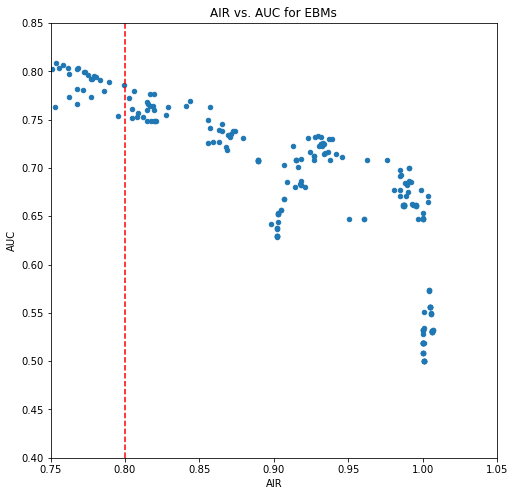

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

Retrain most accurate model above 0.8 AIR

In [38]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict 
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7792 above 0.8 AIR (0.8058).
Remediated EBM retrained with AUC: 0.7792.


Check that other groups are not adversely impacted by change

In [39]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat']) 
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.148
Adverse impact ratio for Black people vs. White people: 0.806
Adverse impact ratio for Females vs. Males: 0.959


In [40]:
# end global timer 
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 107504.85 s.
